You are exploring the wilderness of _Mushroomia_, a land populated by a plethora of diverse fauna and flora. In particular, _Mushroomia_ is known for its unparalleled variety in mushrooms. However, not all the mushrooms in _Mushroomia_ are edible. As you make your way through _Mushroomia_, you would like to know which mushrooms are edible, in order to forage for supplies for your daily mushroom soup.

You have access to:
* _Shroomster Pro Max <sup>TM</sup>_ - a state of the art data collection device, developed by _Mushroomia_, that allows you to collect various data points about any mushroom you encounter in the wild
* _The National Archives on Mushrooms_ - a dataset collected over the years by the government of _Mushroomia_

To address this problem, you decide to use the skills you learnt in CSM148 and train machine learning models on the _The National Archives on Mushrooms_ in order to use your _Shroomster Pro Max <sup>TM</sup>_ to determine whether the mushrooms you encounter on your adventure can be added to your daily mushroom soup.  

This project will be more unstructured than the previous two projects in order to allow you to experience how data science problems are solved in practice. There are two parts to this project: a Jupyter Notebook with your code (where you explore, visualize, process your data and train machine learning models) and a report (where you explain the various choices you make in your implementation and analyze the final performance of your models).

# 1. Loading and Viewing Data



In [1142]:
import pandas as pd
import numpy as np
data_train = pd.read_csv('mushroom_train.csv', sep = ";")
data_test = pd.read_csv('mushroom_test.csv', sep = ";")

data = pd.concat([data_train, data_test], axis=0, ignore_index=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

# 2. Splitting Data into data and Labels

In [1143]:
# Only keep features that shroomster can detect!
features = data.drop('class', axis=1)
labels = data['class']

# 3. Data Exploration and Visualization

cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64


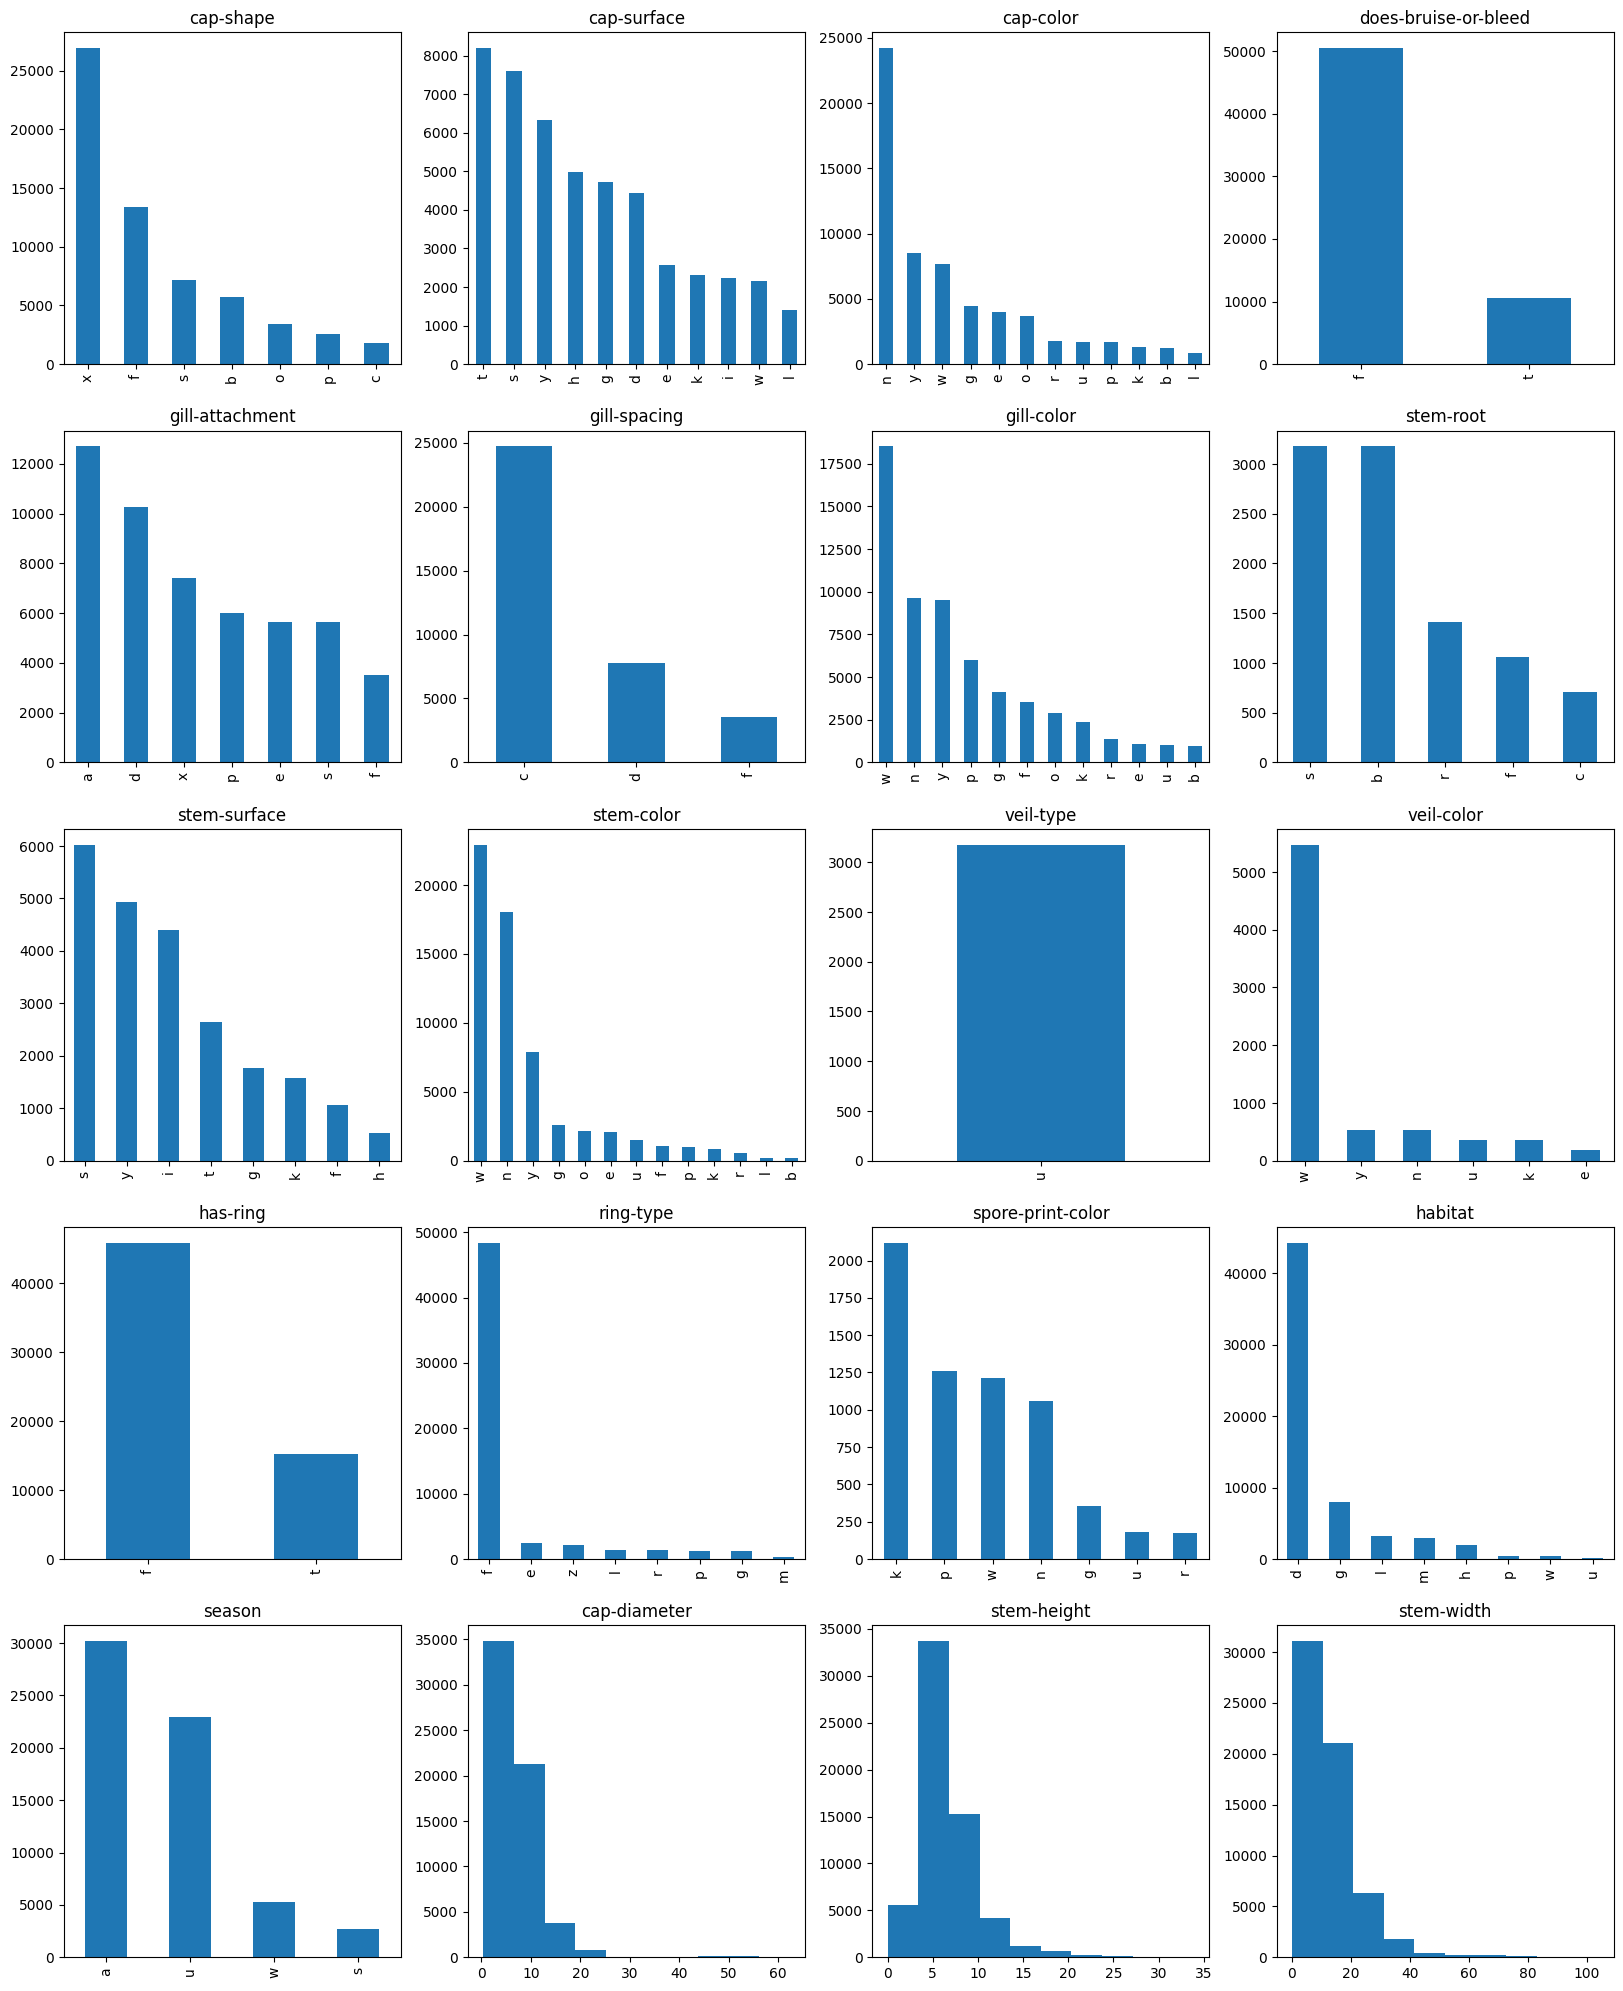

<AxesSubplot:>

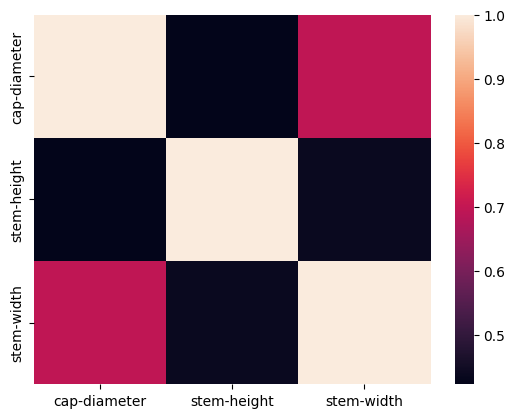

In [1144]:
# Hint: We have done this in both project 1 & 2

%matplotlib inline
import matplotlib.pyplot as plt #plotting package
from sklearn.preprocessing import LabelEncoder

print(features.isnull().sum())

categorical_features = list(features.select_dtypes(include=['object']).columns)

n_rows = len(categorical_features) // 4 + 1
n_cols = min(len(categorical_features), 4)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))

for i, categorical_feature in enumerate(categorical_features):
    row, col = i // n_cols, i % n_cols
    features[categorical_feature].value_counts().plot.bar(ax=ax[row, col])
    ax[row, col].set_title(categorical_feature)

ax[4,1].hist(features["cap-diameter"])
ax[4,1].set_title("cap-diameter")

ax[4,2].hist(features["stem-height"])
ax[4,2].set_title("stem-height")

ax[4,3].hist(features["stem-width"])
ax[4,3].set_title("stem-width")

plt.show()

import seaborn as sns
sns.heatmap(data.corr(method="pearson"))

# 4. Data Processing

In [1145]:
# Hints:
# 1. Convert the "class" column into labels: 'p' (poisonous) -> 0,  'e' (edible) -> 1 
# 2. You can drop columns if you see fit
# 3. See any imcomplete data? We learned how to deal with them in project 1.

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

labels = labels.replace({'p': 0, 'e': 1})

features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          61069 non-null  float64
 1   cap-shape             61069 non-null  object 
 2   cap-surface           46949 non-null  object 
 3   cap-color             61069 non-null  object 
 4   does-bruise-or-bleed  61069 non-null  object 
 5   gill-attachment       51185 non-null  object 
 6   gill-spacing          36006 non-null  object 
 7   gill-color            61069 non-null  object 
 8   stem-height           61069 non-null  float64
 9   stem-width            61069 non-null  float64
 10  stem-root             9531 non-null   object 
 11  stem-surface          22945 non-null  object 
 12  stem-color            61069 non-null  object 
 13  veil-type             3177 non-null   object 
 14  veil-color            7413 non-null   object 
 15  has-ring           

In [1146]:
# gill-spacing, stem-root, stem-surface, veil-type, veil-color, spore-print-color have too many null-values
if "gill-spacing" in features.columns:
    features = features.drop(["gill-spacing"], axis=1)

if "stem-root" in features.columns:
    features = features.drop(["stem-root"], axis=1)
    
if "stem-surface" in features.columns:
    features = features.drop(["stem-surface"], axis=1)
    
if "veil-type" in features.columns:
    features = features.drop(["veil-type"], axis=1)
    
if "veil-color" in features.columns:
    features = features.drop(["veil-color"], axis=1)

if "spore-print-color" in features.columns:
    features = features.drop(["spore-print-color"], axis=1)


# ring-type and habitat have low variance
if "ring-type" in features.columns:
    features = features.drop(["ring-type"], axis=1)
    
if "habitat" in features.columns:
    features = features.drop(["habitat"], axis=1)

# stem-width has high correlation with cap-diameter
if "stem-width" in features.columns:
    features = features.drop(["stem-width"], axis=1)

# 5. Data Augmentation (Creating at least 2 New Features)

In [1147]:
# Similar to Project 1 and 2. 

# stalk-to-cap ratio = stem-height / cap-diameter
features["stalk-to-cap-ratio"] = features["stem-height"] / features["cap-diameter"]

# cap-stem-contrast = {1, if cap color and stem color are different; 0, if cap color and stem color are the same}
def color_contrast(row):
    if row['cap-color'] != row['stem-color']:
        return 1
    else:
        return 0

features["cap-stem-contrast"] = features.apply(color_contrast, axis=1)

features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          61069 non-null  float64
 1   cap-shape             61069 non-null  object 
 2   cap-surface           46949 non-null  object 
 3   cap-color             61069 non-null  object 
 4   does-bruise-or-bleed  61069 non-null  object 
 5   gill-attachment       51185 non-null  object 
 6   gill-color            61069 non-null  object 
 7   stem-height           61069 non-null  float64
 8   stem-color            61069 non-null  object 
 9   has-ring              61069 non-null  object 
 10  season                61069 non-null  object 
 11  stalk-to-cap-ratio    61069 non-null  float64
 12  cap-stem-contrast     61069 non-null  int64  
dtypes: float64(3), int64(1), object(9)
memory usage: 6.1+ MB


In [1148]:
# categorical: cap-shape, cap-surface, cap-color, gill-attachment, gill-spacing, gill-color, stem-color, season
# boolean: does-bruise-or-bleed, has-ring, cap-stem-contrast
# numerical: stem-height, stalk-to-cap-ratio

# Make dataframe with categorical features and numerical features

cat_columns = []
data_num = features.copy(deep=True)

num_columns = list(data_num.columns)
if "cap-shape" in num_columns:
    data_num.drop(["cap-shape"], axis=1, inplace=True)
    cat_columns.append("cap-shape")

if "cap-surface" in num_columns:
    data_num.drop(["cap-surface"], axis=1, inplace=True)
    cat_columns.append("cap-surface")

if "cap-color" in num_columns:
    data_num.drop(["cap-color"], axis=1, inplace=True)
    cat_columns.append("cap-color")

if "gill-attachment" in num_columns:
    data_num.drop(["gill-attachment"], axis=1, inplace=True)
    cat_columns.append("gill-attachment")

if "gill-spacing" in num_columns:
    data_num.drop(["gill-spacing"], axis=1, inplace=True)
    cat_columns.append("gill-spacing")

if "gill-color" in num_columns:
    data_num.drop(["gill-color"], axis=1, inplace=True)
    cat_columns.append("gill-color")

if "stem-color" in num_columns:
    data_num.drop(["stem-color"], axis=1, inplace=True)
    cat_columns.append("stem-color")
    
if "season" in num_columns:
    data_num.drop(["season"], axis=1, inplace=True)
    cat_columns.append("season")
    
if "does-bruise-or-bleed" in num_columns:
    data_num.drop(["does-bruise-or-bleed"], axis=1, inplace=True)
    
if "has-ring" in num_columns:
    data_num.drop(["has-ring"], axis=1, inplace=True)
    
if "cap-stem-contrast" in num_columns:
    data_num.drop(["cap-stem-contrast"], axis=1, inplace=True)
    

In [1149]:
# Pipeline my test data
num_columns = list(data_num)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(categories="auto"))
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_columns),
    ("cat", cat_pipeline, cat_columns)
])

full_pipeline.fit_transform(features)

X = full_pipeline.transform(features)

In [1150]:
X_train = X[:50213, :]
y_train = labels.iloc[:50213]

X_test = X[50213:, :]
y_test = labels.iloc[50213:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((50213, 69), (10856, 69), (50213,), (10856,))

# 6.  Logistic Regression & Statistical Hypothesis Testing

Accuracy: 0.5007369196757553
Precision: 0.7983383685800605
Recall: 0.17020933977455716
F1: 0.2805946376426865
Confusion Matrix: 
[[4379  267]
 [5153 1057]]


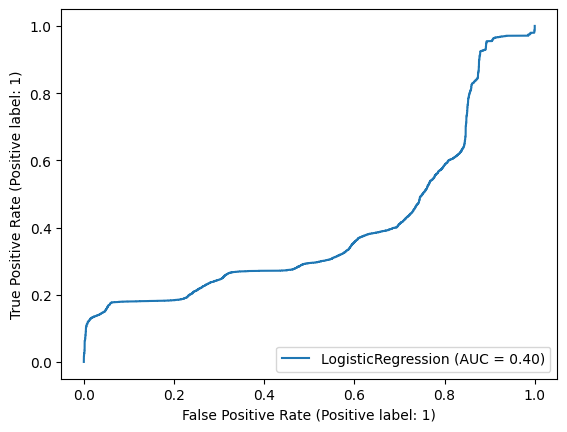

In [1151]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

log_reg_clf = LogisticRegression(max_iter=1000)
log_reg_clf.fit(X_train, y_train)

log_reg_preds = log_reg_clf.predict(X_test)

print("Accuracy: {}".format(metrics.accuracy_score(y_test, log_reg_preds)))
print("Precision: {}".format(metrics.precision_score(y_test, log_reg_preds)))
print("Recall: {}".format(metrics.recall_score(y_test, log_reg_preds)))
print("F1: {}".format(metrics.f1_score(y_test, log_reg_preds)))
print("Confusion Matrix: \n{}".format(metrics.confusion_matrix(y_test, log_reg_preds)))

RocCurveDisplay.from_estimator(log_reg_clf, X_test, y_test)

# 7. Dimensionality Reduction using PCA



In [1152]:
from sklearn.decomposition import PCA
# PCA: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

pca = PCA(n_components=0.95)
pca.fit(X)
X_embed = pca.transform(X)
print('Maintaining 0.95 Variance...')
print('original number of features:', X.shape[1])
print('PCA number of features:', len(pca.components_))
print('average variance:', np.mean(pca.explained_variance_))

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

# 8. Experiment with any 2 other models (Non-Ensemble)

In [ ]:
# Models: https://scikit-learn.org/stable/supervised_learning.html

# 9. Experiment with 1 Ensemble Method

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

# Ensemble Methods: https://scikit-learn.org/stable/modules/ensemble.html
gbreg = GradientBoostingRegressor()
rfreg = RandomForestRegressor()
logreg = LogisticRegression()

gbreg.fit(X_embed_train, y_embed_train)
rfreg.fit(X_embed_train, y_embed_train)
logreg.fit(X_embed_train, y_embed_train)

# 10. Cross-Validation & Hyperparameter Tuning for All 3 Models

In [ ]:
# Cross-Validation: https://scikit-learn.org/stable/modules/cross_validation.html
# Hyperparameter Tuning: https://scikit-learn.org/stable/modules/grid_search.html

# 11. Report Final Results 

In [ ]:
# e.g. Accuracy, Precision etc.